# Projet 6 : Classez des images à l'aide d'algorithmes de Deep Learning
## Contexte
Afin d'aider une association de protection des animaux, il est demandé de classer les images de la base de données de l'association dans le but de déterminer la race des chiens sur les images

## Démarches
Pour réaliser la demande de l'association nous procédons en plusieurs étapes :
- téléchargement des images
- test des différentes corrections appliquables
- création d'un réseau de neurones simples
- test de transfer learning à partir de différents modèles  
Le modèle le plus performant sera ensuite déployé dans un code afin de faciliter son utilisation.

## Modules Python

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pickle
from sklearn.metrics import accuracy_score
import pandas as pd
import PIL.Image

## fonctions utiles

In [2]:
def load_data(DIR, height=200, width=200, batch_size=128):
    train_ds = tf.keras.utils.image_dataset_from_directory(DIR,\
                                                        labels='inferred' ,# labels générés depuis les sous dossier
                                                        label_mode = 'categorical', #créer un vecteur de taille n_class
                                                        color_mode = "rgb", #image de dimension L*H*3
                                                        image_size = (height, width), # rescaling des images
                                                        validation_split=0.2, # %validation
                                                        batch_size=batch_size,
                                                        subset = 'training', #retourne le training set
                                                        seed=43
                                                        )
    test_ds = tf.keras.utils.image_dataset_from_directory(DIR,\
                                                       labels='inferred' ,# labels générés depuis les sous dossier
                                                       label_mode = 'categorical', #créer un vecteur de taille n_class
                                                   color_mode = "rgb", #image de dimension L*H*3
                                                   image_size = (height, width), # rescaling des images
                                                   validation_split=0.2, # %validation
                                                   subset = 'validation', #retourne le training set
                                                   batch_size=batch_size,
                                                   seed=43
                                            )
    return train_ds, test_ds
    

In [3]:
def split_test_val(ds, prct=0.2) :
    n = int(np.ceil(1/prct))
    print(n)
    val_batches = tf.data.experimental.cardinality(ds)
    test_ds = ds.take(val_batches // n)
    val_ds = ds.skip(val_batches // n)
    return val_ds, test_ds

In [4]:
def binary_array(arr):
    arr_bin = np.zeros(arr.shape)
    where = np.argmax(arr, axis=1)
    for i in range(0, where.shape[0]) :
        arr_bin[i, where[i]] = 1
    return arr_bin

## Variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#DIR = "/content/drive/Othercomputers/Mon ordinateur portable/P6_classer_image/"
DIR = "./final_model_MobileNetV2"
DAT_DIR = "./"
hist_first_file = DIR+"/history.pkl"
hist_fine_file = DIR+"/history_fine.pkl"
model_file= DIR+"/model_last_layer.h5"
weights_file = DIR+"/weights_fine_tuning.34-0.7811.h5"
#test_path = DIR+"/test_ds"

## Chargement des fichiers
La base de données est rechargée avec le même seed pour la séparation train/val pour obtenir le même jeu de données.

In [9]:
train_ds, val_ds = load_data(DAT_DIR+"/data/Images", height=160, width=160, batch_size=32)
val_ds, test_ds = split_test_val(val_ds, prct=0.2)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
5


In [10]:
class_names = train_ds.class_names

In [11]:
with open(hist_first_file, 'rb') as f :
    history_first = pickle.load(f)
with open(hist_fine_file, 'rb') as f :
    history_fine = pickle.load(f)
#model = tf.keras.models.load_model(model_file)
model = tf.keras.models.load_model(weights_file)
#with open(test_path + '/element_spec', 'rb') as in_:
#    es = pickle.load(in_)
#test_ds = tf.data.experimental.load(test_path, es,compression='GZIP')

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

## représentation de l'historique de l'apprentissage

In [14]:
n_epochs = len(history_first['accuracy']) + len(history_fine['accuracy'])
print(n_epochs)

61


### précision

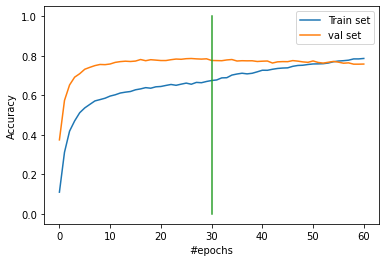

In [15]:
fig, ax = plt.subplots()
ax.plot(range(0,n_epochs), history_first['accuracy']+history_fine['accuracy'], label="Train set")
ax.plot(range(0,n_epochs), history_first['val_accuracy']+history_fine['val_accuracy'], label="val set")
ax.plot([len(history_first['accuracy'])]*2, [0,1])
ax.set_xlabel('#epochs')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

On observe que la performance sur le jeu de données total est plus faible (80% vs 90%). Cela est probablement du à la plus grande complexité à différencier les races.  
Encore une fois le fine tuning (après la ligne verte) ne permet pas d'améliorer la performance du jeu de validation.

### Loss

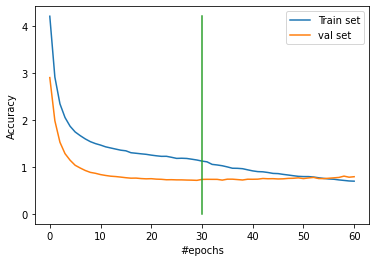

In [16]:
fig, ax = plt.subplots()
ax.plot(range(0,n_epochs), history_first['loss']+history_fine['loss'], label="Train set")
ax.plot(range(0,n_epochs), history_first['val_loss']+history_fine['val_loss'], label="val set")
ax.plot([len(history_first['loss'])]*2, [0,np.max(history_first['loss'])])
ax.set_xlabel('#epochs')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

On confirme le sur-apprentissage lors du fine-tuning

## transformation dataset en array
Le batch Dataset est transformé en numpy array afin d'envoyer les images une par une dans le modèle.

### jeu d'apprentissage

In [28]:
i = 0
for img, lab in train_ds :
    if i == 0 :
        train_img = img
        train_lab = lab
    else :
        train_img = np.concatenate((train_img, img))
        train_lab = np.concatenate((train_lab, lab))
    i+=1
print(f"train_img shape = {train_img.shape}")
print(f"train_lab shape = {train_lab.shape}")

train_img shape = (16464, 160, 160, 3)
train_lab shape = (16464, 120)


### jeu de validation

In [34]:
i = 0
for img, lab in val_ds :
    if i == 0 :
        val_img = img
        val_lab = lab
    else :
        val_img = np.concatenate((val_img, img))
        val_lab = np.concatenate((val_lab, lab))
    i+=1
print(f"val_img shape = {val_img.shape}")
print(f"val_lab shape = {val_lab.shape}")

val_img shape = (3316, 160, 160, 3)
val_lab shape = (3316, 120)


### jeu de test

In [17]:
i = 0
for img, lab in test_ds :
    if i == 0 :
        test_img = img
        test_lab = lab
    else :
        test_img = np.concatenate((test_img, img))
        test_lab = np.concatenate((test_lab, lab))
    i+=1
print(f"test_img shape = {test_img.shape}")
print(f"test_lab shape = {test_lab.shape}")

test_img shape = (800, 160, 160, 3)
test_lab shape = (800, 120)


## performance du modèle

### jeu d'apprentissage

In [30]:
train_pred = model.predict(train_img)

In [31]:
train_pred_bin = binary_array(train_pred)

In [33]:
train_acc = accuracy_score(train_lab, train_pred_bin)
print(f"Précision sur le jeu de test = {train_acc:.4f}")

Précision sur le jeu de test = 0.8532


### jeu de validation

In [35]:
val_pred = model.predict(val_img)

In [36]:
val_pred_bin = binary_array(val_pred)

In [37]:
val_acc = accuracy_score(val_lab, val_pred_bin)
print(f"Précision sur le jeu de test = {val_acc:.4f}")

Précision sur le jeu de test = 0.7808


### jeu de test
Le jeu de test est totalement inconnu du modèle

In [19]:
test_pred = model.predict(test_img)

In [20]:
test_pred_bin = binary_array(test_pred)


In [21]:
test_acc = accuracy_score(test_lab, test_pred_bin)
print(f"Précision sur le jeu de test = {test_acc}")

Précision sur le jeu de test = 0.7725


La précision sur le jeu de test est très similaire à la précision du jeu de validation.

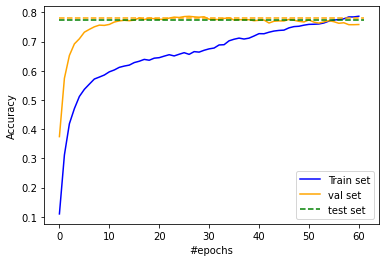

In [43]:
fig, ax = plt.subplots()
ax.plot(range(0,n_epochs), history_first['accuracy']+history_fine['accuracy'], label="Train set", color="blue")
ax.plot(range(0,n_epochs), history_first['val_accuracy']+history_fine['val_accuracy'], label="val set", color="orange")
ax.plot([0, n_epochs], [val_acc]*2, linestyle="--", color='orange')
ax.plot([0, n_epochs], [test_acc]*2, linestyle="--", color='green', label="test set")
#ax.plot([len(history_first['accuracy'])]*2, [0,1])
ax.set_xlabel('#epochs')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

## représentation des erreurs de prédictions

### chargement de données d'exemples
On charge des images pour chaque label afin de se représenter les erreurs de prédictions.

In [23]:
example = pd.DataFrame(columns=['labels', 'image'])
for dir in os.listdir(DAT_DIR+"data/Images"):
    img = os.listdir(DAT_DIR+"data/Images/"+dir)[0]
    example = example.append({'labels':dir,'image':PIL.Image.open(DAT_DIR+"data/Images/"+dir+'/'+img)}, \
                           ignore_index=True)
example.head()

,labels,image
0,n02085620-Chihuahua,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,n02085782-Japanese_spaniel,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,n02085936-Maltese_dog,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,n02086079-Pekinese,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,n02086240-Shih-Tzu,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [24]:
example['labels_int'] = example['labels'].apply(class_names.index)

### Nombre d'erreurs

In [25]:
test_lab_index = np.argmax(test_lab, axis=1)
test_pred_index = np.argmax(test_pred_bin, axis=1)

In [26]:
error = np.where(np.not_equal(test_lab_index, test_pred_index))[0]
print(f"Nombre d'erreurs sur le jeu d'apprentissage : {error.shape[0]}, soit {error.shape[0]/test_lab_index.shape[0]*100:.2f}%")

Nombre d'erreurs sur le jeu d'apprentissage : 182, soit 22.75%


### Visualisation des erreurs

Race prédite : n02088632-bluetick avec une probabilité de 0.67 au lieu de n02100236-German_short-haired_pointer avec une probabilité de 0.33


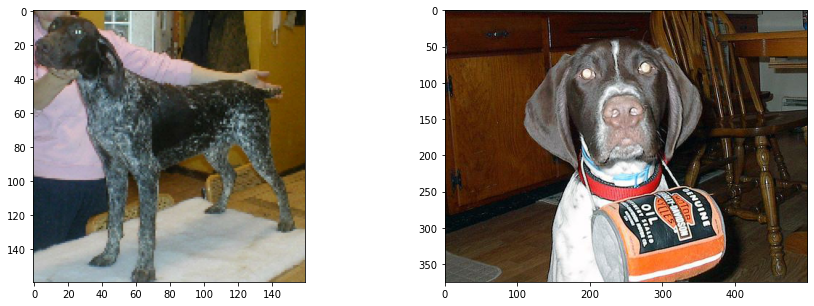

Race prédite : n02108551-Tibetan_mastiff avec une probabilité de 0.78 au lieu de n02105855-Shetland_sheepdog avec une probabilité de 0.06


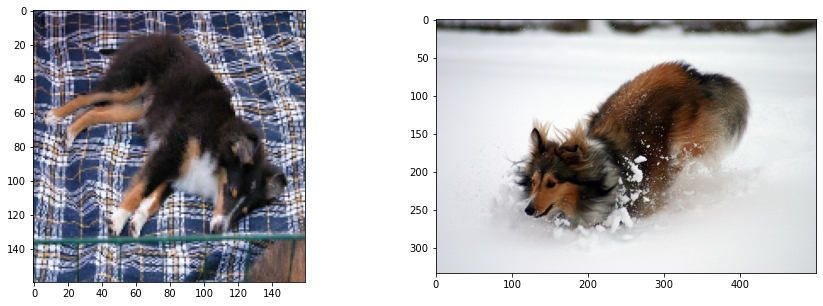

Race prédite : n02111129-Leonberg avec une probabilité de 0.50 au lieu de n02105251-briard avec une probabilité de 0.24


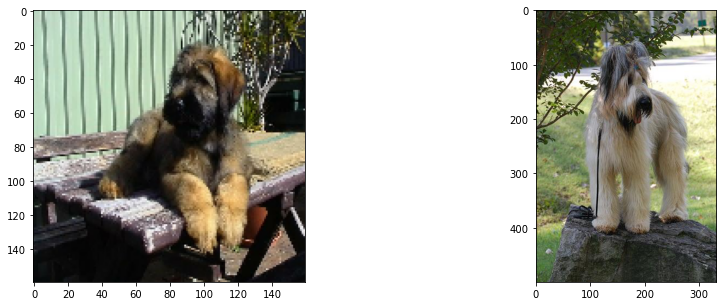

Race prédite : n02108422-bull_mastiff avec une probabilité de 0.91 au lieu de n02093428-American_Staffordshire_terrier avec une probabilité de 0.04


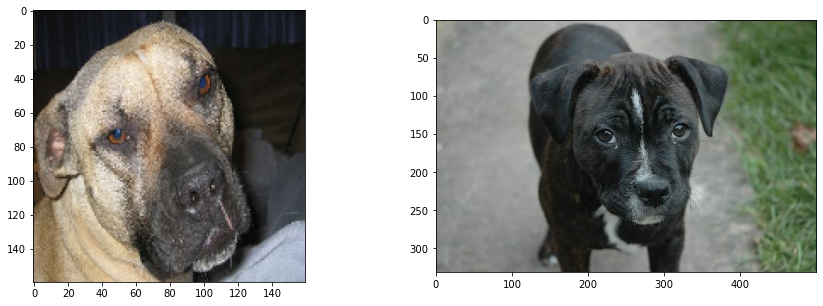

Race prédite : n02085936-Maltese_dog avec une probabilité de 0.40 au lieu de n02113712-miniature_poodle avec une probabilité de 0.14


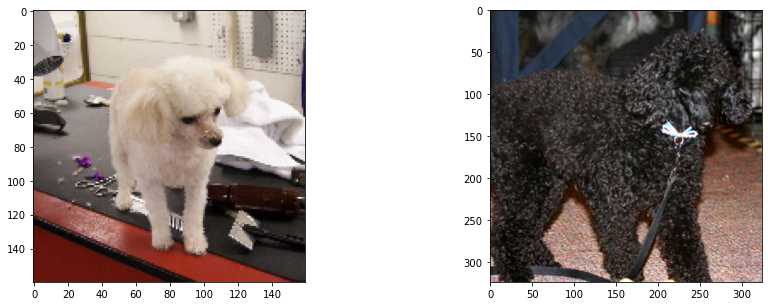

Race prédite : n02091134-whippet avec une probabilité de 0.61 au lieu de n02093428-American_Staffordshire_terrier avec une probabilité de 0.27


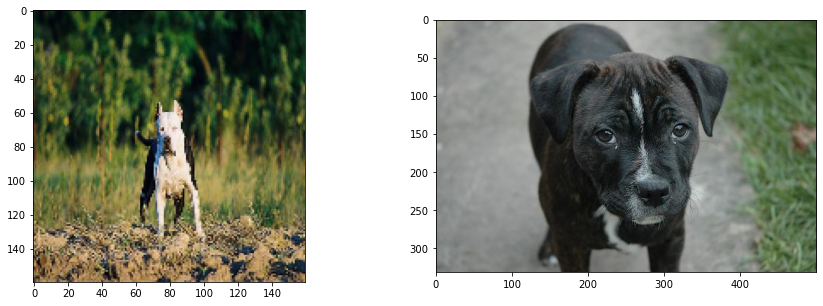

Race prédite : n02108915-French_bulldog avec une probabilité de 0.93 au lieu de n02093428-American_Staffordshire_terrier avec une probabilité de 0.02


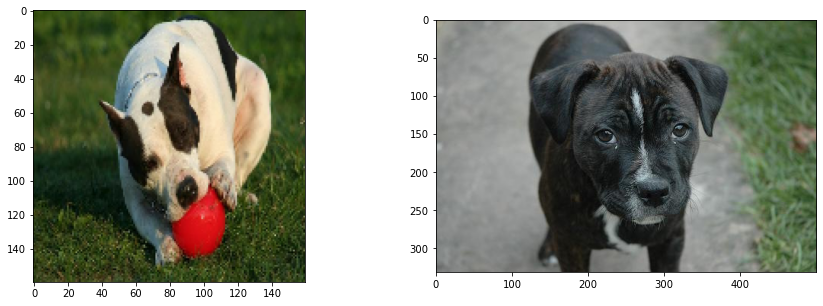

Race prédite : n02107908-Appenzeller avec une probabilité de 0.80 au lieu de n02107683-Bernese_mountain_dog avec une probabilité de 0.03


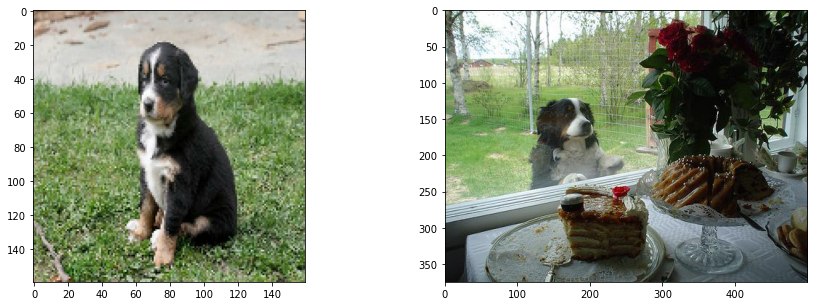

Race prédite : n02102040-English_springer avec une probabilité de 0.35 au lieu de n02090622-borzoi avec une probabilité de 0.23


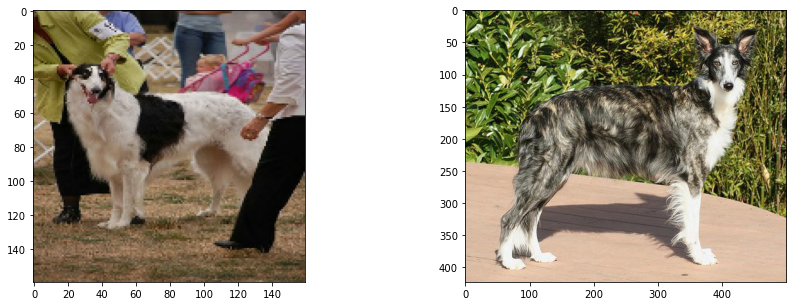

Race prédite : n02091032-Italian_greyhound avec une probabilité de 0.35 au lieu de n02091134-whippet avec une probabilité de 0.33


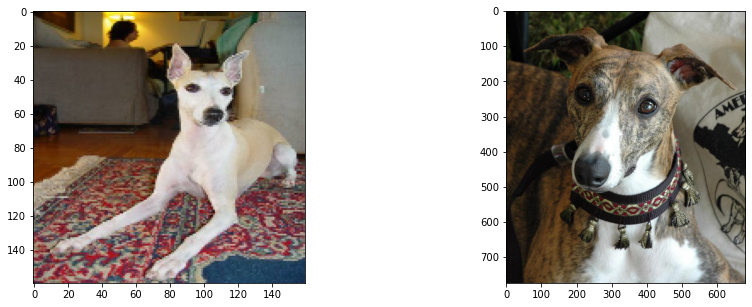

In [27]:
n = np.random.randint(0, error.shape[0], size=10)
for i in error[n] :
    print("="*50)
    y_pred = test_pred_index[i]
    y_true = test_lab_index[i]
    print(f"Race prédite : {class_names[y_pred]} avec une probabilité de {test_pred[i,y_pred]:.2f} au lieu de {class_names[y_true]} avec une probabilité de {test_pred[i,y_true]:.2f}")
    fig, axs = plt.subplots(ncols=2, figsize=(15,5))
    axs[0].imshow(test_img[i,:,:,:].astype(int))
    axs[1].imshow(example[example['labels_int'] == y_true]['image'].values[0])
    #print(example[example['labels_int'] == y_true])
    plt.show()


On remarque quand dans les cas tirés aléatoirement, les différences entre les races sont faibles et difficilement identifiable par un humain, d'où la difficulté pour l'algorithme.